#PREDICTING GDP PER CAPITA FOR SUB-SAHARAN AFRICA

# ARIMA MODEL 
(AUTOREGRESSIVE INTEGRATED MOVING AVERAGE)
ARIMA(p,d,q), 
where p = number of lag observations included in the model,
      d = number of times that the raw observations are differenced,
      q = size of the moving average window.

In [1]:
import matplotlib.pyplot as plt  #Import visualization libraries
from matplotlib import pyplot
import pandas as pd
import numpy as np
import torch.optim as optim #The neural network optimizer
from sklearn.model_selection import train_test_split #For splitting the data
from sklearn.neighbors import KNeighborsRegressor #To define the kNN model
from statsmodels.tsa.arima_model import ARIMA
#Inspect the kNN model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import seaborn as sns #For visualization
#For LR
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [2]:
#For functions like (go.) which we use for visualization
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.3 MB/s 


In [2]:
#Upload file from local directory
#For images you can upload a zip file
from google.colab import files
uploaded = files.upload()

Saving Theses complete data.csv to Theses complete data.csv


In [3]:
df = pd.read_csv("Theses complete data.csv")
data = df.values
df.head()

,YEAR,GDP per capita (current US$),"Electricity production from renewable sources, excluding hydroelectric (kWh)",Access to electricity (% of population),Total greenhouse gas emissions (kt of CO2 equivalent),"Population, total",Current health expenditure per capita (current US$),"Government expenditure on education, total (% of GDP)","Inflation, consumer prices (annual %)","Employment to population ratio, 15+, total (%) (modeled ILO estimate)"
0,1971,451.694009,163000000.0,NaN,NaN,298284475,NaN,NaN,NaN,NaN
1,1972,497.240127,165000000.0,NaN,NaN,306359650,NaN,NaN,NaN,NaN
2,1973,617.167676,170000000.0,NaN,NaN,314761504,NaN,NaN,NaN,NaN
3,1974,784.227147,175000000.0,NaN,NaN,323500333,NaN,NaN,19.598394,NaN
4,1975,844.409778,172000000.0,NaN,NaN,332583481,NaN,NaN,15.224099,NaN


# (A) DATA WRANGLING

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 10 columns):
 #   Column                                                                        Non-Null Count  Dtype  
---  ------                                                                        --------------  -----  
 0   YEAR                                                                          51 non-null     int64  
 1   GDP per capita (current US$)                                                  51 non-null     float64
 2   Electricity production from renewable sources, excluding hydroelectric (kWh)  45 non-null     float64
 3   Access to electricity (% of population)                                       28 non-null     float64
 4   Total greenhouse gas emissions (kt of CO2 equivalent)                         30 non-null     float64
 5   Population, total                                                             51 non-null     int64  
 6   Current health expenditure per capit

USING kNN's MULTIVARIATE METHOD FOR IMPUTATION OF MISSING VALUES

In [5]:
#Multivariate imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0) #model NaNs in round-robin fashion
imp.fit(data)

x_prep = data[:,:]
clean = np.round(imp.transform(x_prep))

In [6]:
print('Array:', clean[0:2])

Array: [[1.97100000e+03 4.52000000e+02 1.63000000e+08 0.00000000e+00
  8.70753000e+05 2.98284475e+08 1.90000000e+01 4.00000000e+00
  1.90000000e+01 1.34000000e+02]
 [1.97200000e+03 4.97000000e+02 1.65000000e+08 1.00000000e+00
  8.85610000e+05 3.06359650e+08 2.20000000e+01 4.00000000e+00
  1.90000000e+01 1.34000000e+02]]


In [7]:
#Turn our data back to pandas
clean = pd.DataFrame(clean, columns = ['YEAR', 'GDP per capita (current US$)',	'Electricity production from renewable sources, excluding hydroelectric (kWh)',	'Access to electricity (% of population)',	'Total greenhouse gas emissions (kt of CO2 equivalent)',	'Population, total',	'Current health expenditure per capita (current US$)',	'Government expenditure on education, total (% of GDP)',	'Inflation, consumer prices (annual %)',	'Employment to population ratio, 15+, total (%) (modeled ILO estimate)'])
print(clean.head)

<bound method NDFrame.head of       YEAR  GDP per capita (current US$)  \
0   1971.0                         452.0   
1   1972.0                         497.0   
2   1973.0                         617.0   
3   1974.0                         784.0   
4   1975.0                         844.0   
5   1976.0                         895.0   
6   1977.0                         952.0   
7   1978.0                        1021.0   
8   1979.0                        1194.0   
9   1980.0                        1469.0   
10  1981.0                        2062.0   
11  1982.0                        1831.0   
12  1983.0                        1521.0   
13  1984.0                        1283.0   
14  1985.0                        1169.0   
15  1986.0                        1148.0   
16  1987.0                        1251.0   
17  1988.0                        1271.0   
18  1989.0                        1245.0   
19  1990.0                        1426.0   
20  1991.0                        1431.0   
21

# (B) EXPLORATORY DATA ANALYSIS

In [8]:
# create timeseries plot
import plotly.graph_objs as go
import plotly.offline as py
X=clean['YEAR']
y=clean['GDP per capita (current US$)']
layout = go.Layout(title= 'Sub-Saharan African GDP per capita PPP 1960-202021 current international $',
    xaxis = dict(ticks='', nticks=43),
    yaxis = dict(nticks=20))
data = [go.Scatter(x=X,y=y)]
fig =go.Figure(data=data, layout=layout)
py.iplot(fig, filename='heatmap',show_link=False)


It is visually indicative from the time plot above that Sub-Saharan GDP per capita follows a positive additive growth pattern. Therefore, we regard it as a non-stationary time series.

In [30]:
#EXAMINING THE DYNAMIC CHANGE
ts_1=clean
ts_1['mean']=clean['GDP per capita (current US$)'].pct_change().mean()
X=clean['YEAR']
y_2=clean['GDP per capita (current US$)'].pct_change()
y1=ts_1['mean']
layout = go.Layout(title= 'Sub-Saharan African GDP per capita PPP growth dynamic 1960-2020 (current US$)',
    xaxis = dict(ticks='', nticks=40),
    yaxis = dict(nticks=20),legend=dict(x=0.7, y=1))
trace0 = go.Scatter(x=X,y=y_2, mode = 'lines',name="SSA GDPpc $ growth 196712021", marker = dict(size=12, color='red'))
trace1 = go.Scatter(x=X,y=y1, mode = 'lines', name="GDP Mean ", marker = dict(size=12, color='darkcyan'))
data = [trace0,trace1]
fig =go.Figure(data=data, layout=layout)
py.iplot(fig, filename='heatmap',show_link=False)

See from the dynamic growth of the time series for the percentae change of GDP per capita looks stationary over time. We can however identify some cyclical patterns. Experiencing a fluctuation in positive, then a negative growth almost every consecutive year from 1961-1975. Its biggest growth in 1980 (4.04%). The growth is at its lowest in 1983. Post-depression, growth had a short positive rise (2010-2011) before dropping again negatively. As of last year, 2021, there is a bullish trend (8% growth) above the 4.7% average of the series.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2103: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



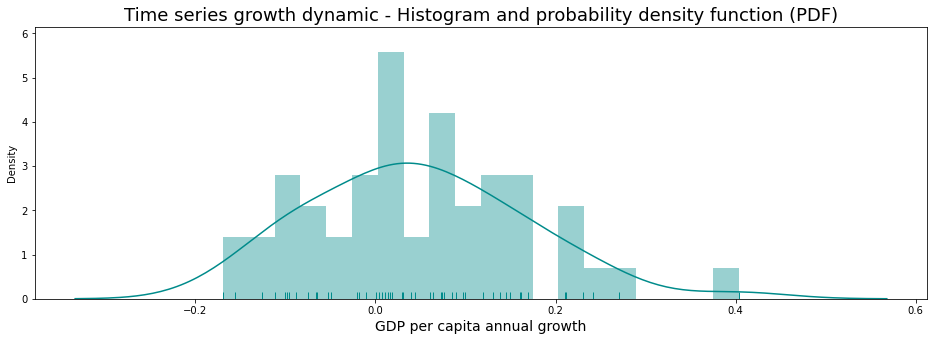

In [10]:
f, ax = plt.subplots(figsize=(16, 5)); plt.title('Distribution')
sns.distplot(clean['GDP per capita (current US$)'].pct_change(),color='darkcyan', bins=20,rug=True,hist_kws={"density":True})
plt.rc('xtick')    # fontsize of the tick X labels 
plt.rc('ytick')    # fontsize of the tick Y labels
plt.title('Time series growth dynamic - Histogram and probability density function (PDF)', size=18)
plt.xlabel('GDP per capita annual growth', size=14)
plt.show()

We can see a very asymmetric distribution with a long right side tail.

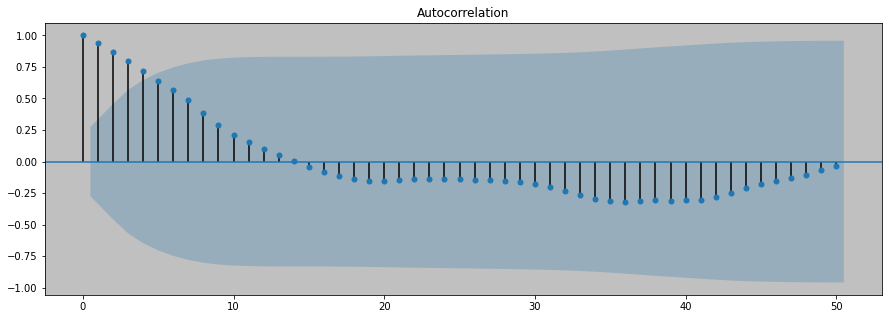

In [11]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(15,5))
ax.set_facecolor('silver')
sm.graphics.tsa.plot_acf(y,ax=ax,lags=50)
plt.show()

This correlogram to lag 50 confirms that the data is clearly non-stationary and follows an accumulative autoregressive growth pattern up to the 14th lag. It then starts accumulating negative autocorrelation from the 15th lag onward. For a stationary time series, the ACF will drop to zero relatively quickly. Either way, the ACF of non-stationary data decreases slowly. The blue margin shows the 95% confidence interval. It is the expected result for a growing additive time series, with a trend.

We test for stationarity using the unit root test, the Dickey-Fuller test.

In [12]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(y)
result

(-0.9548692205726815,
 0.7693669653964403,
 1,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 525.9241096739622)

In [13]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.954869
p-value: 0.769367
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599


The null hypothesis of the test is that the time series can be represented by a unit root, so it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary. With the ADfuller test, when our p-value > 0.05, we fail to reject the null hypotheses. The more negative this statistic, the more likely we are to reject the null hypothesis. From our test results, the test statistic is larger than the critical values at 1,5,10% so we fail to reject the null hypotheses. Also, becaue our p-value (0.856) > 0.05, we fail to reject the null hypotheses (fail to refuse non-stationarity in the data)

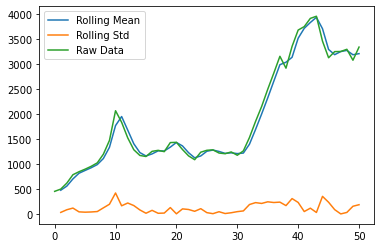

In [14]:
clean['rolling_mean'] = clean['GDP per capita (current US$)'].rolling(2).mean()
clean['rolling_std'] = clean['GDP per capita (current US$)'].rolling(2).std()
plt.plot(clean['rolling_mean'], label='Rolling Mean')
plt.plot(clean['rolling_std'], label='Rolling Std')
plt.plot(clean['GDP per capita (current US$)'], label='Raw Data')
plt.legend()
plt.show()

We see that the time series has an increasing trend with the mean showing its non-stationarity. 

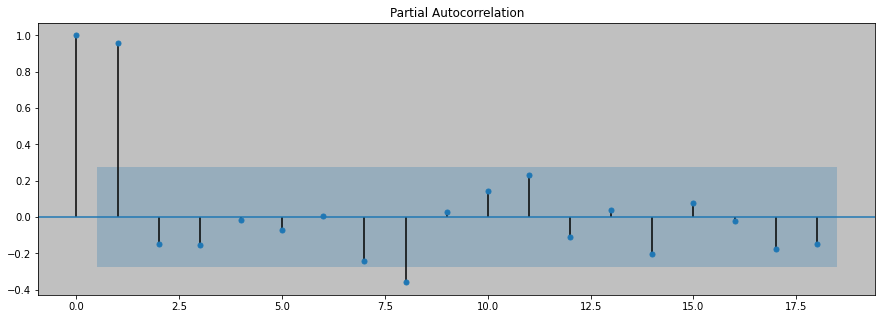

In [15]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(15,5))
ax.set_facecolor('silver')
sm.graphics.tsa.plot_pacf(y,ax=ax)
plt.show()

# MAKE OUR SERIES STATIONARY

Making our time series stationary is important because if our series is consistently increasing/decreasing over time, it means that either the mean is not constant or the variance-autocovariances are time-dependent, which makes more difficult to develop mathematical theory and models for time series. In summary, we can only study the series patterns for the given period and we cannot build generalized predictive ARIMA models with it.

In [29]:
# first order difference of the time series
y_diff = y.diff().dropna()
#y_diff = pd.Series(y_diff)

layout = go.Layout(title= 'Sub-Saharan African GDP per capita First order differencing',
xaxis = dict(ticks='', nticks=43),
yaxis = dict(nticks=20),legend=dict(x=0.7, y=1))

trace0 = go.Scatter(x=y_diff.index, y=y_diff.values, mode = 'lines+markers',name="SSA GDPpc PPP $ growth 1971-2021", marker = dict(size=12, color='black'))
data = [trace0]
fig =go.Figure(data=data, layout=layout)
py.iplot(fig, filename='heatmap',show_link=False)

In [17]:
from statsmodels.tsa.stattools import adfuller
result02 = adfuller(y_diff)
result02
print('ADF Statistic: %f' % result02[0])
print('p-value: %f' % result02[1])
print('Critical Values:')
for key, value in result02[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.750507
p-value: 0.000068
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599


We see that our p value has dropped to less than 0.05. Also, the ADF test statistic is less than the critical values at 1,5, and 10%. This means we fail to reject the null hypotheses after the first order differencing.

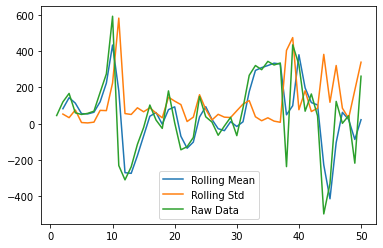

In [18]:
clean['rolling_mean'] = y_diff.rolling(2).mean()
clean['rolling_std'] = y_diff.rolling(2).std()
plt.plot(clean['rolling_mean'], label='Rolling Mean')
plt.plot(clean['rolling_std'], label='Rolling Std')
plt.plot(y_diff, label='Raw Data')
plt.legend()
plt.show()

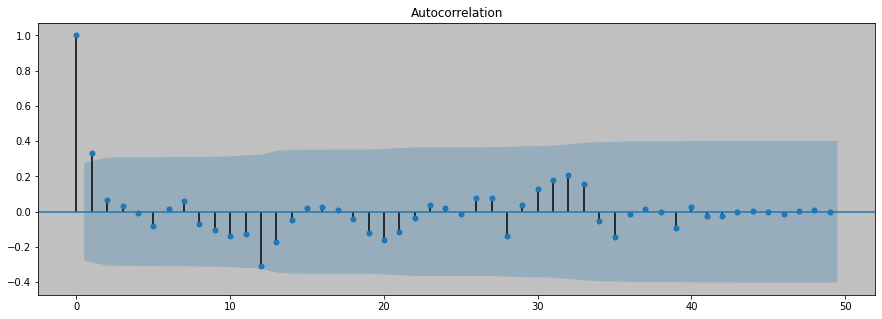

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_facecolor('silver')
plt.rc('xtick', labelsize=16)
sm.graphics.tsa.plot_acf(y_diff,ax=ax,lags=49)
plt.show()

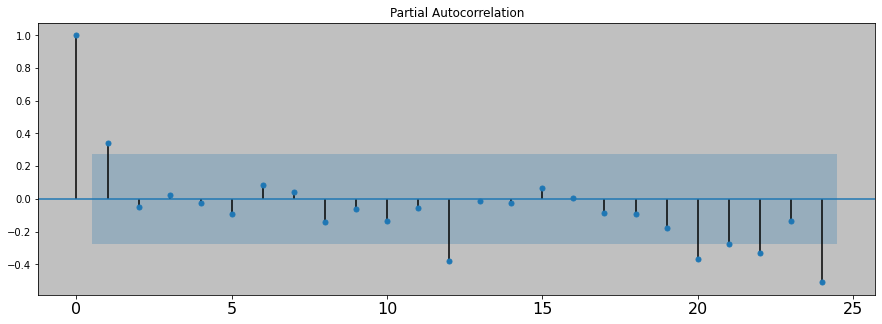

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_facecolor('silver')
sm.graphics.tsa.plot_pacf(y_diff,ax=ax, lags=24) #Lags=49 because of first order diff
plt.show()

I reduced the lags to 24 when doing the PACF because the function needed less than 50% of available lags. I used the same number of lags for the ACF and still gives the same value as for 60 lags. Partial autocorrelation function (PACF) is more useful during the specification process for an autoregressive model. It displays only the correlation between two observations that the shorter lags between those observations do not explain. Analysts use partial autocorrelation plots to specify regression models with time series data and Auto Regressive Integrated Moving Average (ARIMA) models.

# (C) MODEL

In [21]:
# p=12 because it is the first above the significance line.
# d=1 since order of integration 1 makes the series stationary
# q=12 
mod = sm.tsa.statespace.SARIMAX(clean['GDP per capita (current US$)'].values,order=(12,1,12),enforce_stationarity=True,enforce_invertibility=True, maxiter=1000, method='css')
mod_results1 = mod.fit()
print(mod_results1.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   51
Model:             SARIMAX(12, 1, 12)   Log Likelihood                -663.324
Date:                Wed, 21 Dec 2022   AIC                           1376.647
Time:                        15:54:12   BIC                           1424.448
Sample:                             0   HQIC                          1394.850
                                 - 51                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1599      0.005     29.192      0.000       0.149       0.171
ar.L2          1.1205      0.021     54.486      0.000       1.080       1.161
ar.L3         -0.9924      0.020    -49.086      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



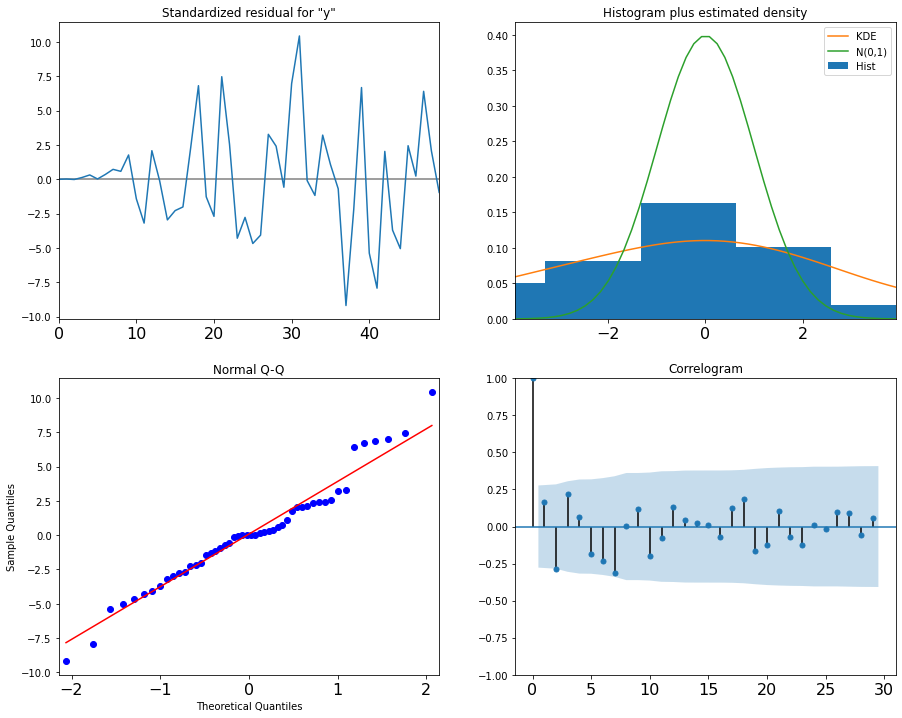

In [22]:
mod_results1.plot_diagnostics(figsize=(15, 12),lags=29)
plt.show()

The standarized residual plot of the fitted model in the upper left corner appears to be white noise as it does not display any pattern. The correlogram looks like that of discrete white noise. Its time series residuals show low correlations with lagged residuals. Also, it has a strong peak at lag 0.

In [23]:
forecast=mod_results1.predict(start=0,end=64)
forecast=pd.DataFrame(forecast, columns = ['projection'])
forecast.index=['1971','1972','1973','1974','1975','1976','1977',
                '1978','1979','1980','1981','1982','1983','1984','1985','1986',
                '1987','1988','1989','1991', '1992', '1993', '1994', '1995', '1996',
                '1997', '1998','1999', '2000', '2001', '2002', '2003', '2004', 
                '2005', '2006', '2007','2008', '2009', '2010', '2011', '2012', 
                '2013', '2014', '2015', '2016','2017','2018','2019','2020','2021',
                '2022','2023','2024','2025','2026','2027','2028','2029','2030',
                '2031','2032','2032','2033','2034','2035']


In [25]:
# Create traces
trace01 = go.Scatter(
    x = clean['YEAR'],
    y = clean['GDP per capita (current US$)'],
    mode = 'markers',
    name = 'Actual GDP per cap',marker = dict(size=7))
trace02 = go.Scatter(
    x = forecast.iloc[2:].index,
    y = forecast.iloc[2:].projection,
    mode = 'lines+markers',
    name = 'Arima model (12,1,12) in sample model & projection to 2035',marker = dict(size=7),opacity = 0.6)

layout = go.Layout(title= 'In-sample prediction and out-of-sample forecasting to 2035 per capita - GDP PPP US$ SSA',
    xaxis = dict(ticks='', nticks=43),
    yaxis = dict(nticks=20), legend=dict(x=0.1, y=1))
data = [trace01, trace02]
fig =go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter-mode')

In [28]:
from sklearn.metrics import mean_absolute_percentage_error
import math
from math import sqrt
y_true = clean['GDP per capita (current US$)']
y_pred = forecast.iloc[0:51].projection
# report performance
mse = mean_squared_error(y_true, y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_true, y_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
print('RMSE: '+str(rmse))
mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: '+str(mape))

MSE: 97485.66808725592
MAE: 259.4965739141527
RMSE: 312.22694964921897
MAPE: 0.202268803057757


We see that our ARIMA (12,1,12) model predicts that without any underlying economic structural change; at the current growth patterns, the GDP per capita in Sub-Saharan Africa will not increase. It will only be within the range upwards of 2900 US dollars and not more than 3400 US dollars.

We have to account that the forecasting results of this model are only predicted values, accounting for the underlying structure of the Time Series over the last 61 years.